In [1]:
N = 12
cols = ['height', 'mass', 'income', 'iq', 'pages', 'age', 'bmi', 'work_exp', 'friends', 'test_time']
COL_1 = N % 5
COL_2 = N**2 % 5 + 5
COL_1, COL_2

(2, 9)

In [2]:
import pandas as pd
import numpy as np
from math import atanh, tanh, sqrt
from scipy.stats import stats, spearmanr, kendalltau, pearsonr, norm, rankdata, f
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import statistics
from itertools import combinations

In [3]:
df_1 = pd.read_csv('../../datasets/students_simple.csv', usecols=[cols[COL_1]])
s_1 = pd.to_numeric(df_1[cols[COL_1]], errors="coerce").dropna()
s_1

0     430
1     640
2     610
3     330
4     420
5     290
6     480
7     610
8     840
9     330
10    560
11    450
12    350
13    310
14    380
15    340
16    660
17    450
18    540
19    750
Name: income, dtype: int64

In [4]:
df_2 = pd.read_csv('../../datasets/students_simple.csv', usecols=[cols[COL_2]])
s_2 = pd.to_numeric(df_2[cols[COL_2]], errors="coerce").dropna()
s_2

0      8.5
1      6.2
2      6.8
3     12.0
4      7.5
5     10.0
6      7.2
7      4.2
8      3.5
9      9.5
10     7.8
11     8.0
12     6.0
13     4.8
14     8.6
15    10.0
16     4.5
17    12.5
18    10.5
19     6.5
Name: test_time, dtype: float64

In [5]:
#Фехнера#
def fechner_correlation(x, y):
    x_mean, y_mean = np.mean(x), np.mean(y)
    same_sign = np.sum((x - x_mean) * (y - y_mean) > 0)
    n = len(x)
    return (2 * same_sign - n) / n

print(fechner_correlation(s_1, s_2))

-0.4


In [6]:
#Пирсона + доверительный интервал#
def pearson_corr_ci(x, y, alpha=0.05):
    x = np.asarray(x); y = np.asarray(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    r, p = pearsonr(x, y)
    n = x.size
    z = atanh(r)
    se = 1 / sqrt(n - 3)
    zcrit = norm.ppf(1 - alpha/2)
    lo_p, hi_p = tanh(z - zcrit*se), tanh(z + zcrit*se)
    return r, p, (lo_p, hi_p)

r, p, ci = pearson_corr_ci(s_1, s_2)
print(f"r={r:.3f}, p={p:.3g}, 95% ДИ=({ci[0]:.3f}, {ci[1]:.3f})")

r=-0.570, p=0.00871, 95% ДИ=(-0.809, -0.170)


In [7]:
#Спирмена#
rho, p_s = spearmanr(s_1, s_2)
print(f"rho={rho:.3f}, p={p:.3g}")

rho=-0.539, p=0.00871


In [8]:
#Кенделла
tau, p_k = kendalltau(s_1, s_2)
print(tau, p)

-0.43617638325413816 0.008708171880438034


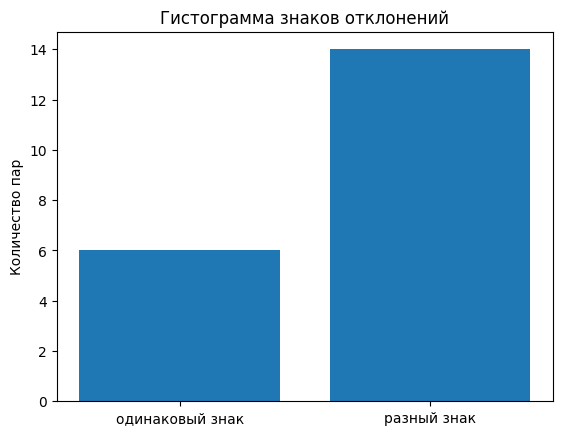

In [9]:
#Гистограмма Фехнера#
x = np.asarray(s_1); y = np.asarray(s_2)
signs = np.sign((x - x.mean()) * (y - y.mean()))
counts = [(signs > 0).sum(), (signs < 0).sum()]

plt.bar(['одинаковый знак', 'разный знак'], counts)
plt.title('Гистограмма знаков отклонений')
plt.ylabel('Количество пар')
plt.show()

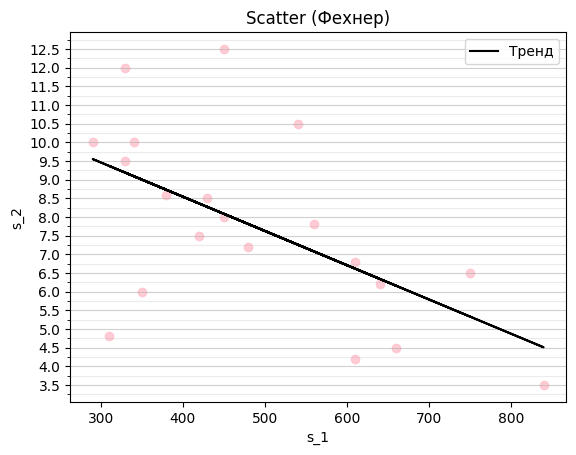

In [10]:
#Scatter plot Фехнера#
fig, ax = plt.subplots()
ax.scatter(s_1, s_2, color='pink', alpha=0.8)

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(True, which='major', axis='y', alpha=0.6)
ax.grid(True, which='minor', axis='y', alpha=0.25)

ax.set_title('Scatter (Фехнер)')
ax.set_xlabel('s_1'); ax.set_ylabel('s_2')
m, b = np.polyfit(s_1, s_2, 1)
plt.plot(s_1, m*s_1 + b, color='black', linestyle='-', label='Тренд')
plt.legend()
plt.show()

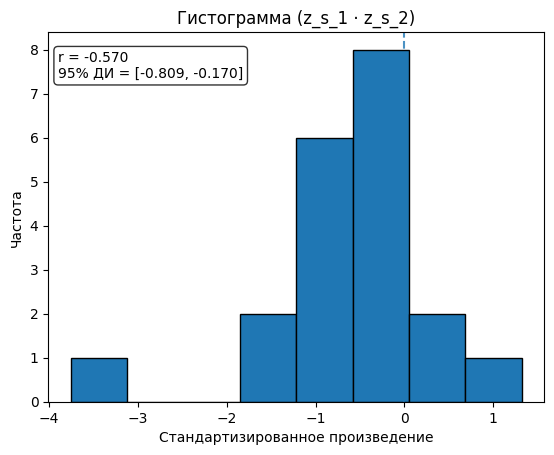

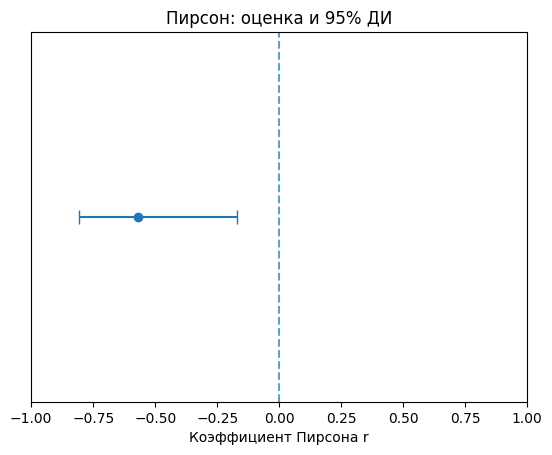

In [11]:
#Гистограмма Пирсона + доверительный интервал#
x = np.asarray(s_1)
y = np.asarray(s_2)
r = r                  
lo, hi = ci 

zx = (x - x.mean()) / x.std(ddof=1)
zy = (y - y.mean()) / y.std(ddof=1)
prod = zx * zy

plt.figure()
plt.hist(prod, bins='auto', edgecolor='black')
plt.axvline(0, linestyle='--', alpha=0.8)
plt.title('Гистограмма (z_s_1 · z_s_2)')
plt.xlabel('Стандартизированное произведение'); plt.ylabel('Частота')
plt.text(0.02, 0.95, f"r = {r:.3f}\n95% ДИ = [{lo:.3f}, {hi:.3f}]",
         transform=plt.gca().transAxes, va='top', ha='left',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

plt.figure()
plt.errorbar([r], [0], xerr=[[r-lo], [hi-r]], fmt='o', capsize=5)
plt.axvline(0, linestyle='--', alpha=0.7)
plt.yticks([]); plt.xlabel('Коэффициент Пирсона r')
plt.title('Пирсон: оценка и 95% ДИ')
plt.xlim(min(lo, -1.0), max(hi, 1.0))
plt.show()

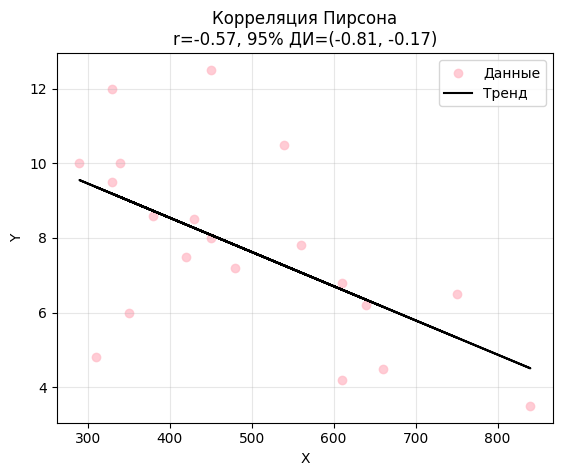

In [12]:
#Scatter plot Пирсона + доверительный интервал#
x = np.asarray(s_1)
y = np.asarray(s_2)
r = r
ci = ci

plt.figure()
plt.scatter(s_1, s_2, color='pink', alpha=0.8, label='Данные')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='black', linestyle='-', label='Тренд')

plt.title(f'Корреляция Пирсона\nr={r:.2f}, 95% ДИ=({ci[0]:.2f}, {ci[1]:.2f})')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

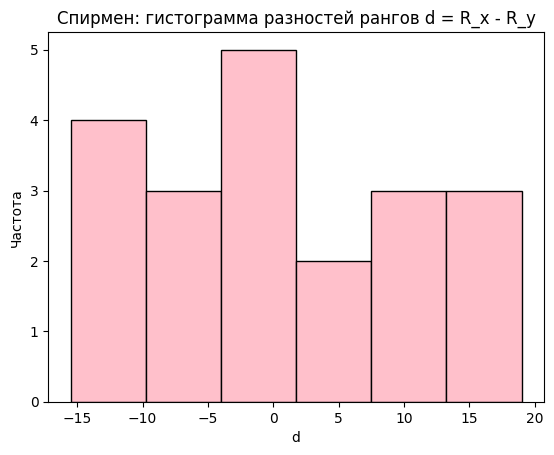

In [13]:
#Гистограмма Спирмена#
x = np.asarray(s_1); y = np.asarray(s_2)

Rx = rankdata(x, method='average')
Ry = rankdata(y, method='average')
d = Rx - Ry

plt.figure()
plt.hist(d, bins='auto', color='pink', edgecolor='black')
plt.title('Спирмен: гистограмма разностей рангов d = R_x - R_y')
plt.xlabel('d'); plt.ylabel('Частота')
plt.show()

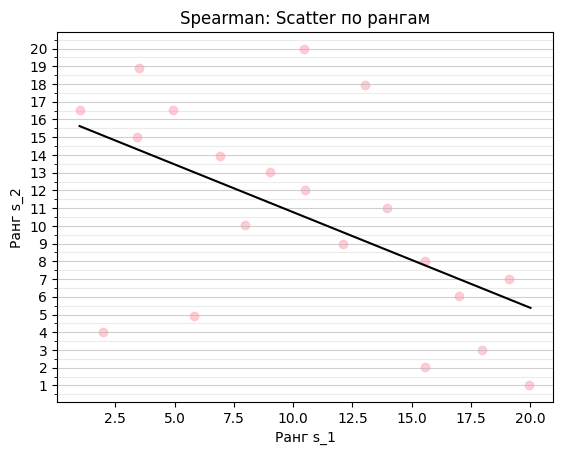

In [14]:
#Scatter plot Спирмена#
x = np.asarray(s_1)
y = np.asarray(s_2)

Rx = rankdata(x, method='average')
Ry = rankdata(y, method='average')

j = 0.08
Rx_j = Rx + np.random.default_rng(0).normal(0, j, size=len(Rx))
Ry_j = Ry + np.random.default_rng(1).normal(0, j, size=len(Ry))

fig, ax = plt.subplots()
ax.scatter(Rx_j, Ry_j, alpha=0.8, color='pink')

m, b = np.polyfit(Rx, Ry, 1)
xs = np.linspace(Rx.min(), Rx.max(), 100)
ax.plot(xs, m*xs + b, linestyle='-', color='black')

ax.set_title('Spearman: Scatter по рангам')
ax.set_xlabel('Ранг s_1'); ax.set_ylabel('Ранг s_2')

ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(True, which='major', axis='y', alpha=0.6)
ax.grid(True, which='minor', axis='y', alpha=0.25)

plt.show()

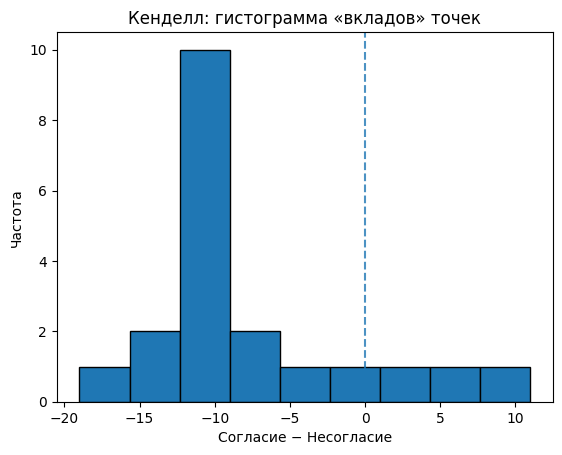

In [15]:
#Гистограмма Кенделла#
x = np.asarray(s_1); y = np.asarray(s_2)
n = len(x)
score = np.zeros(n, dtype=int)

for i in range(n):
    s = np.sign((x[i] - x) * (y[i] - y))
    s[i] = 0                      
    score[i] = s[s != 0].sum()   

plt.hist(score, bins='auto', edgecolor='black')
plt.title('Кенделл: гистограмма «вкладов» точек')
plt.xlabel('Согласие − Несогласие'); plt.ylabel('Частота')
plt.axvline(0, linestyle='--', alpha=0.8)
plt.show()

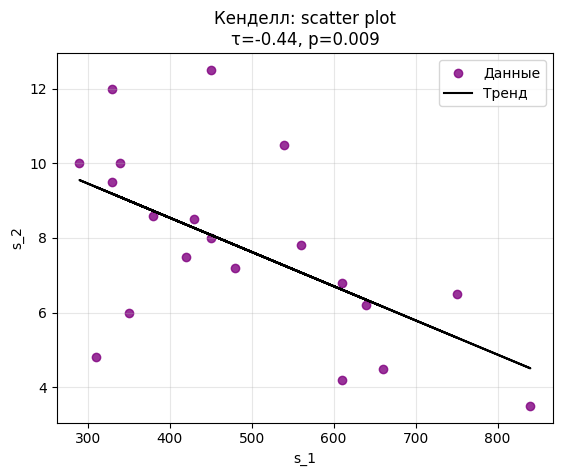

In [16]:
#Scatter plot Кенделла#
x = np.asarray(s_1)
y = np.asarray(s_2)

tau, p = tau, p

plt.figure()
plt.scatter(x, y, color='purple', alpha=0.8, label='Данные')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='black', linestyle='-', label='Тренд')

plt.title(f'Кенделл: scatter plot\nτ={tau:.2f}, p={p:.3f}')
plt.xlabel('s_1')
plt.ylabel('s_2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [17]:
#Уравнение регрессии: линейная#
def ols_linear(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[m], y[m]

    x_mean, y_mean = x.mean(), y.mean()
    Sxx = np.sum((x - x_mean)**2)
    Sxy = np.sum((x - x_mean)*(y - y_mean))
    w1 = Sxy / Sxx
    w0 = y_mean - w1 * x_mean
    return w1, w0

w1, w0 = ols_linear(s_1, s_2)
print(f"y = {w1:.4f} * x + {w0:.4f}")

y = -0.0092 * x + 12.2089


In [18]:
#Уравнение регрессии: квадратичная#
def ols_quadratic(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    n = len(x)

    X = np.vstack([np.ones(n), x, x**2]).T
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    w0, w1, w2 = w
    return w2, w1, w0

w2, w1, w0 = ols_quadratic(s_1, s_2)
print(f"y = {w2:.4f}·x² + {w1:.4f}·x + {w0:.4f}")

y = -0.0000·x² + 0.0097·x + 7.6017


In [19]:
#Уравнение регрессии: гиперболическая#
def ols_hyperbolic(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    z = 1 / x
    z_mean, y_mean = z.mean(), y.mean()
    Szz = np.sum((z - z_mean)**2)
    Szy = np.sum((z - z_mean)*(y - y_mean))

    w1 = Szy / Szz
    w0 = y_mean - w1 * z_mean
    return w1, w0

w1, w0 = ols_hyperbolic(s_1, s_2)
print(f"y = {w1:.4f}/x + {w0:.4f}")

y = 1832.3465/x + 3.6149


In [20]:
#Уравнение регрессии: показательная#
def ols_exponential(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    mask = y > 0      
    x, y = x[mask], y[mask]
    ly = np.log(y)

    xm, lym = x.mean(), ly.mean()
    Sxx = np.sum((x - xm)**2)
    Sxy = np.sum((x - xm)*(ly - lym))

    b1 = Sxy / Sxx
    b0 = lym - b1 * xm

    w1 = np.exp(b1)
    w0 = np.exp(b0)
    return w1, w0 

w1, w0 = ols_exponential(s_1, s_2)
print(f"y = {w0:.4f} * {w1:.4f}^x")

y = 14.1216 * 0.9987^x


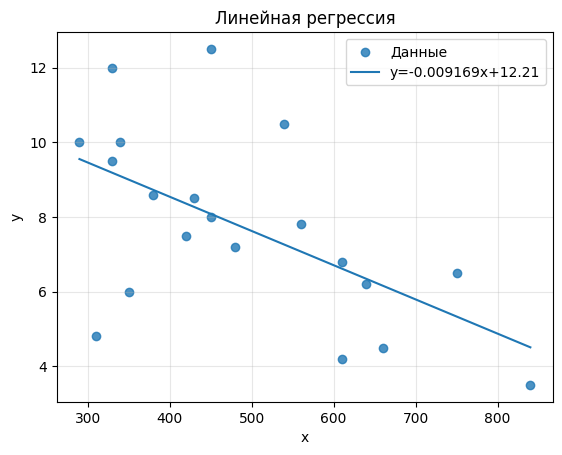

In [21]:
x = np.asarray(s_1, float); y = np.asarray(s_2, float)

xm, ym = x.mean(), y.mean()
Sxx = np.sum((x-xm)**2)
Sxy = np.sum((x-xm)*(y-ym))
w1 = Sxy / Sxx
w0 = ym - w1*xm

xs = np.linspace(x.min(), x.max(), 400)
plt.figure()
plt.scatter(x, y, alpha=0.8, label='Данные')
plt.plot(xs, w1*xs + w0, label=f'y={w1:.4g}x+{w0:.4g}')
plt.title('Линейная регрессия'); plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(alpha=0.3); plt.show()

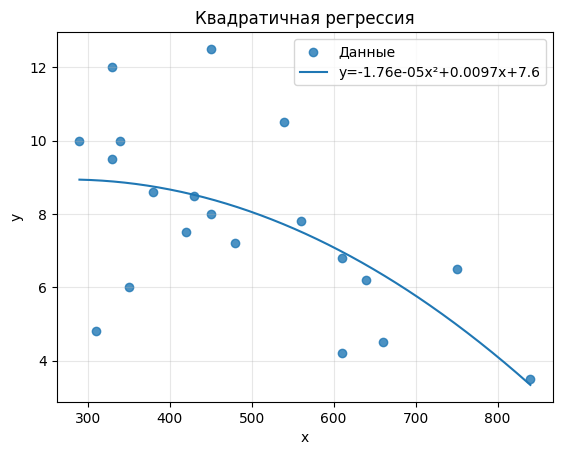

In [22]:
x = np.asarray(s_1, float); y = np.asarray(s_2, float)
X = np.vstack([np.ones_like(x), x, x**2]).T
w = np.linalg.inv(X.T @ X) @ (X.T @ y)  
w0, w1, w2 = w

xs = np.linspace(x.min(), x.max(), 400)
plt.figure()
plt.scatter(x, y, alpha=0.8, label='Данные')
plt.plot(xs, w2*xs**2 + w1*xs + w0, label=f'y={w2:.3g}x²+{w1:.3g}x+{w0:.3g}')
plt.title('Квадратичная регрессия'); plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(alpha=0.3); plt.show()

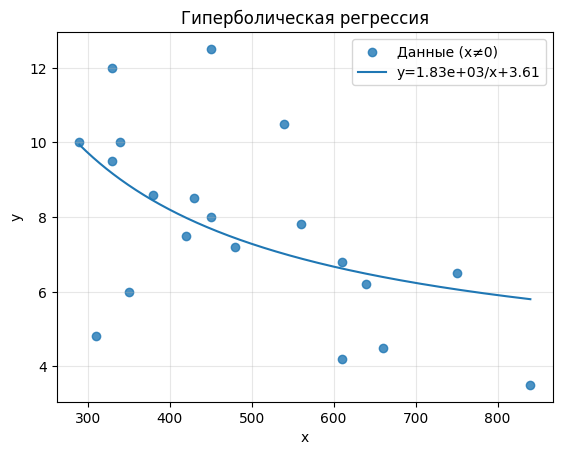

In [23]:
x = np.asarray(s_1, float); y = np.asarray(s_2, float)
m = x != 0
z = 1 / x[m]; yy = y[m]
zm, ym = z.mean(), yy.mean()
Szz = np.sum((z-zm)**2)
Szy = np.sum((z-zm)*(yy-ym))
w1 = Szy / Szz
w0 = ym - w1*zm

xs = np.linspace(x.min(), x.max(), 400)
ms = xs != 0
plt.figure()
plt.scatter(x[m], y[m], alpha=0.8, label='Данные (x≠0)')
plt.plot(xs[ms], w1/xs[ms] + w0, label=f'y={w1:.3g}/x+{w0:.3g}')
plt.title('Гиперболическая регрессия'); plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(alpha=0.3); plt.show()

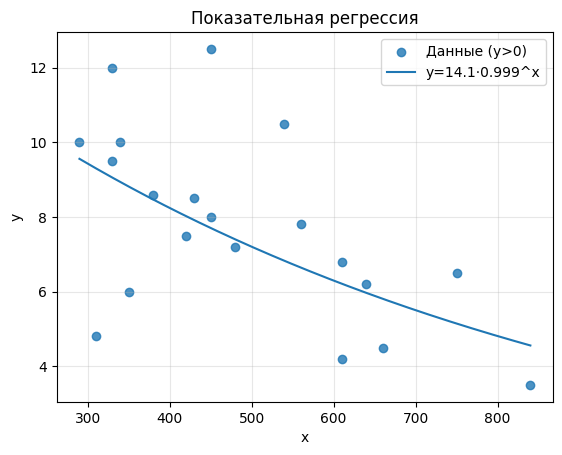

In [24]:
x = np.asarray(s_1, float); y = np.asarray(s_2, float)
m = y > 0
xx, yy = x[m], y[m]
ly = np.log(yy)

xm, lym = xx.mean(), ly.mean()
Sxx = np.sum((xx-xm)**2)
Sxy = np.sum((xx-xm)*(ly-lym))
b1 = Sxy / Sxx
b0 = lym - b1*xm
w1 = np.exp(b1)
w0 = np.exp(b0)

xs = np.linspace(x.min(), x.max(), 400)
plt.figure()
plt.scatter(xx, yy, alpha=0.8, label='Данные (y>0)')
plt.plot(xs, w0 * (w1**xs), label=f'y={w0:.3g}·{w1:.3g}^x')
plt.title('Показательная регрессия'); plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(alpha=0.3); plt.show()

In [25]:
#линейная
def fisher_test(x, y, y_pred, k, alpha=0.05):
    n = len(x)
    RSS = np.sum((y - y_pred)**2)
    TSS = np.sum((y - y.mean())**2)
    R2 = 1 - RSS/TSS
    F_stat = (R2/(k-1)) / ((1-R2)/(n-k))
    F_crit = f.ppf(1-alpha, k-1, n-k)
    return R2, F_stat, F_crit, F_stat > F_crit

x = s_1
y = s_2

y_pred = -0.0092*x+12.2089

R2, F_stat, F_crit, passed = fisher_test(x, y, y_pred, k=2)
print(f"R²={R2:.3f}, F={F_stat:.3f}, Fкр={F_crit:.3f}, модель {'соответствует' if passed else 'не соответствует'} данным")

R²=0.325, F=8.656, Fкр=4.414, модель соответствует данным


In [26]:
#квадратичная
def fisher_test(x, y, y_pred, k, alpha=0.05):
    n = len(x)
    RSS = np.sum((y - y_pred)**2)
    TSS = np.sum((y - y.mean())**2)
    R2 = 1 - RSS/TSS
    F_stat = (R2/(k-1)) / ((1-R2)/(n-k))
    F_crit = f.ppf(1-alpha, k-1, n-k)
    return R2, F_stat, F_crit, F_stat > F_crit

x = s_1
y = s_2

y_pred = -0.0000*x**2 + 0.0097*x + 7.6017

R2, F_stat, F_crit, passed = fisher_test(x, y, y_pred, k=3)
print(f"R²={R2:.3f}, F={F_stat:.3f}, Fкр={F_crit:.3f}, модель {'соответствует' if passed else 'не соответствует'} данным")

R²=-4.565, F=-6.973, Fкр=3.592, модель не соответствует данным


In [27]:
#гиперболическая
def fisher_test(x, y, y_pred, k, alpha=0.05):
    n = len(x)
    RSS = np.sum((y - y_pred)**2)
    TSS = np.sum((y - y.mean())**2)
    R2 = 1 - RSS/TSS
    F_stat = (R2/(k-1)) / ((1-R2)/(n-k))
    F_crit = f.ppf(1-alpha, k-1, n-k)
    return R2, F_stat, F_crit, F_stat > F_crit

x = s_1
y = s_2

y_pred = 1832.3465/x + 3.6149

R2, F_stat, F_crit, passed = fisher_test(x, y, y_pred, k=2)
print(f"R²={R2:.3f}, F={F_stat:.3f}, Fкр={F_crit:.3f}, модель {'соответствует' if passed else 'не соответствует'} данным")

R²=0.243, F=5.771, Fкр=4.414, модель соответствует данным


In [28]:
def fisher_test(x, y, y_pred, k, alpha=0.05):
    n = len(x)
    RSS = np.sum((y - y_pred)**2)
    TSS = np.sum((y - y.mean())**2)
    R2 = 1 - RSS/TSS
    F_stat = (R2/(k-1)) / ((1-R2)/(n-k))
    F_crit = f.ppf(1-alpha, k-1, n-k)
    return R2, F_stat, F_crit, F_stat > F_crit

x = s_1
y = s_2

y_pred = 14.1216 * 0.9987**x

R2, F_stat, F_crit, passed = fisher_test(x, y, y_pred, k=2)
print(f"R²={R2:.3f}, F={F_stat:.3f}, Fкр={F_crit:.3f}, модель {'соответствует' if passed else 'не соответствует'} данным")

R²=0.299, F=7.683, Fкр=4.414, модель соответствует данным
